# Fundamentals of Bayesian Analysis with PyMC3 and TensorFlow Probability

## Bayesian Linear Regression

(*Taken from TFP proposed example*)  
In a Bayesian linear regression, we assign a likelihood function for Y~ Normal (𝛍, 𝛔) where 𝛍 = 𝛂 + 𝛃 X. Note that this is the same function as the standard linear regression model. However, we treat parameters 𝛂, 𝛃 and 𝛔 as random variables with probability distributions. We then use Bayes’ theorem to figure out the posterior distributions for 𝛂, 𝛃, and 𝛔:

Y ∼ N(μ, σ2); μ = α + βX

P(𝛂, 𝛃, 𝛔| Y, X) = P(Y| 𝛂, 𝛃, 𝛔, X) P(𝛂, 𝛃, 𝛔|X)/P(Y|X)

We need to assign prior probability distributions to all parameters: 𝛂 ~ Normal (a, b), 𝛃 ~ Normal (c, d), 𝛔 ~ Uniform (e, f). Prior distributions depend on your previous knowledge/hypotheses about parameters.

After building the model with the prior distributions and the likelihood function, we use the Hamiltonian Monte Carlo algorithm to sample from the posterior distribution.

In [50]:
# Install PyMC3 library if not installed

try:
  print(pymc3.__version__)

except:
  !pip install pymc3
  !pip install arviz

!pip install tensorflow_probability==0.8.0rc0

In [0]:
# Import required libraries

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# TensorFlow imports
import tensorflow as tf
"""
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()
"""

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
plt.style.use('seaborn-darkgrid')

tfd = tfp.distributions
tfb = tfp.bijectors

#PyMC3 imports
import pymc3 as pm

In [0]:
# Generate artificial dataset

# Initialize random number generator
np.random.seed(123)

# True parameter values
true_alpha = 1
true_sigma = 1
true_beta = 1.5

# Size of dataset
size = 1000

# Predictor variable (standard normal distributed)
X = np.random.randn(size)

# Simulate outcome variable
Y = true_alpha + true_beta*X + np.random.randn(size)*true_sigma # np.random.uniform(size=size, low=-0.5, high=0.5)*sigma

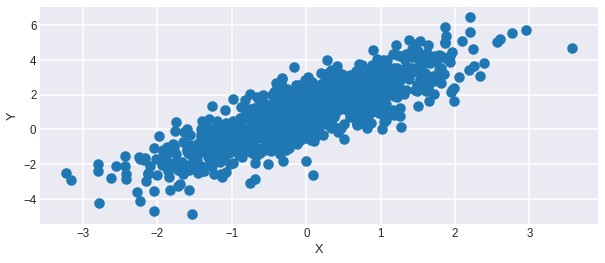

In [53]:
# Plot the data

%matplotlib inline

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4), squeeze=False) 
axes[0][0].scatter(X, Y)
axes[0][0].set_ylabel('Y'); axes[0][0].set_xlabel('X');

### PyMC3

In [0]:
# Define a model context manager

bayesian_regression_model = pm.Model()

with bayesian_regression_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', lower=0, upper=1)

    # Expected value of outcome (yields deterministic variable)
    mu = alpha + beta*X

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [55]:
# We can find point estimates (Not recommended for drawing conclusions, but good as sampling seed)
# Allows many optimization methods from scipy.optimize module, param 'method'.

map_estimate = pm.find_MAP(model=bayesian_regression_model)

map_estimate

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,385.3, ||grad|| = 39.985: 100%|██████████| 20/20 [00:00<00:00, 1101.00it/s] 


{'alpha': array(1.0071955),
 'beta': array(1.47003758),
 'sigma': array(0.95754031),
 'sigma_interval__': array(3.11581257)}

In [56]:
# Sampling estimation

with bayesian_regression_model:

    # instantiate sampler
    step_method = pm.HamiltonianMC()

    # draw 10000 posterior samples. Trace contains Posterior' intrinsic distribution.
    trace = pm.sample(10000, step=step_method, tune=1500, init=map_estimate)

Sequential sampling (2 chains in 1 job)
HamiltonianMC: [sigma, beta, alpha]
100%|██████████| 11500/11500 [00:09<00:00, 1232.27it/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.


In [57]:
# Summary of posterior sampling result

pm.summary(trace).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.0073,0.0301,0.0003,0.9496,1.0676,8696.1491,1.0000
beta,1.4701,0.0302,0.0003,1.4115,1.5284,9979.8167,1.0003
sigma,0.9579,0.0195,0.0002,0.9220,0.9955,8077.4561,1.0002


mean_a = -0.028697017122483015
mean_b = 0.02009586632519994
mean_s = 0.5008464218262841


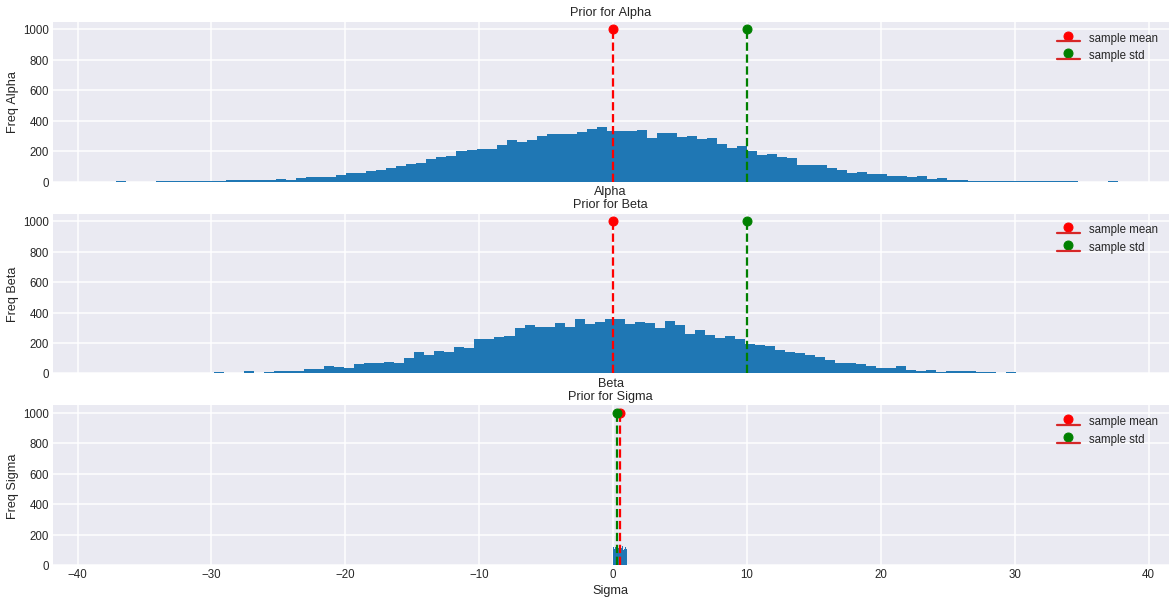

In [58]:
# Plot samples from prior distributions

%matplotlib inline

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,10), squeeze=False)

p_a = pm.Normal.dist(mu=0, sigma=10).random(size=11500)
p_b = pm.Normal.dist(mu=0, sigma=10).random(size=11500)
p_s = pm.Uniform.dist(lower=0, upper=1).random(size=11500)

axes[0][0].hist(p_a, bins=100)
axes[0][0].stem([p_a.mean()], [1000], 'r--', markerfmt='ro', label='sample mean')
axes[0][0].stem([p_a.std()], [1000], 'g--', markerfmt='go', label='sample std')
axes[0][0].set_ylabel('Freq Alpha'); 
axes[0][0].set_xlabel('Alpha');
axes[0][0].legend();
axes[0][0].set_title('Prior for Alpha');
print("mean_a = {}".format(p_a.mean()))

axes[1][0].hist(p_b, bins=100)
axes[1][0].stem([p_b.mean()], [1000], 'r--', markerfmt='ro', label='sample mean')
axes[1][0].stem([p_b.std()], [1000], 'g--', markerfmt='go', label='sample std')
axes[1][0].set_ylabel('Freq Beta'); 
axes[1][0].set_xlabel('Beta');
axes[1][0].legend();
axes[1][0].set_title('Prior for Beta');
print("mean_b = {}".format(p_b.mean()))

axes[2][0].hist(p_s, bins=100)
axes[2][0].stem([p_s.mean()], [1000], 'r--', markerfmt='ro', label='sample mean')
axes[2][0].stem([p_s.std()], [1000], 'g--', markerfmt='go', label='sample std')
axes[2][0].set_ylabel('Freq Sigma'); 
axes[2][0].set_xlabel('Sigma');
axes[2][0].legend();
axes[2][0].set_title('Prior for Sigma');

print("mean_s = {}".format(p_s.mean()))


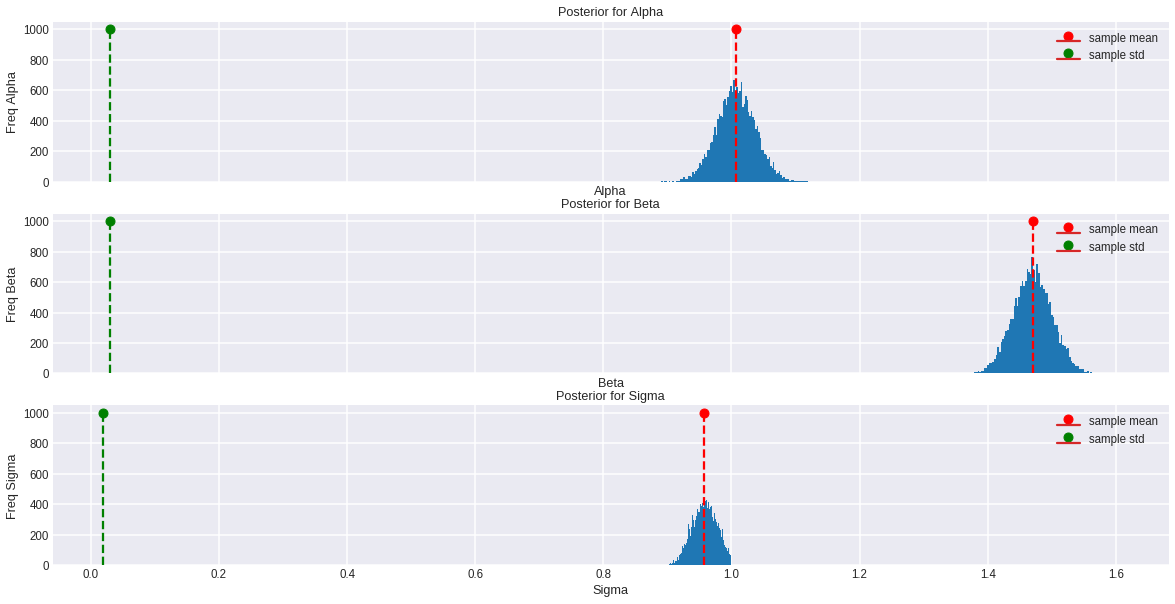

In [59]:
# Plot samples from the posteriors

%matplotlib inline

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,10), squeeze=False)

axes[0][0].hist(trace.get_values('alpha'), bins=100)
axes[0][0].stem([trace.get_values('alpha').mean()], [1000], 'r--', markerfmt='ro', label='sample mean')
axes[0][0].stem([trace.get_values('alpha').std()], [1000], 'g--', markerfmt='go', label='sample std')
axes[0][0].set_ylabel('Freq Alpha'); 
axes[0][0].set_xlabel('Alpha');
axes[0][0].legend();
axes[0][0].set_title('Posterior for Alpha');

axes[1][0].hist(trace.get_values('beta'), bins=100)
axes[1][0].stem([trace.get_values('beta').mean()], [1000], 'r--', markerfmt='ro', label='sample mean')
axes[1][0].stem([trace.get_values('beta').std()], [1000], 'g--', markerfmt='go', label='sample std')
axes[1][0].set_ylabel('Freq Beta'); 
axes[1][0].set_xlabel('Beta');
axes[1][0].legend();
axes[1][0].set_title('Posterior for Beta');

axes[2][0].hist(trace.get_values('sigma'), bins=100)
axes[2][0].stem([trace.get_values('sigma').mean()], [1000], 'r--', markerfmt='ro', label='sample mean')
axes[2][0].stem([trace.get_values('sigma').std()], [1000], 'g--', markerfmt='go', label='sample std')
axes[2][0].set_ylabel('Freq Sigma'); 
axes[2][0].set_xlabel('Sigma');
axes[2][0].legend();
axes[2][0].set_title('Posterior for Sigma');


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a2fc86710>],
      dtype=object)

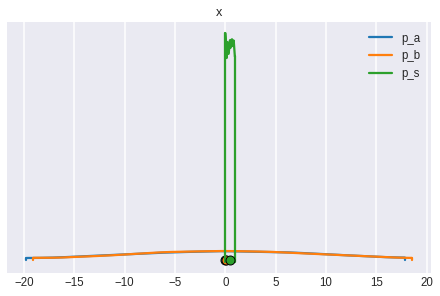

In [60]:
# Plot Priors directly with PyMC3

pm.plot_density(data=[p_a, p_b, p_s], data_labels=['p_a', 'p_b', 'p_s'], group='prior')

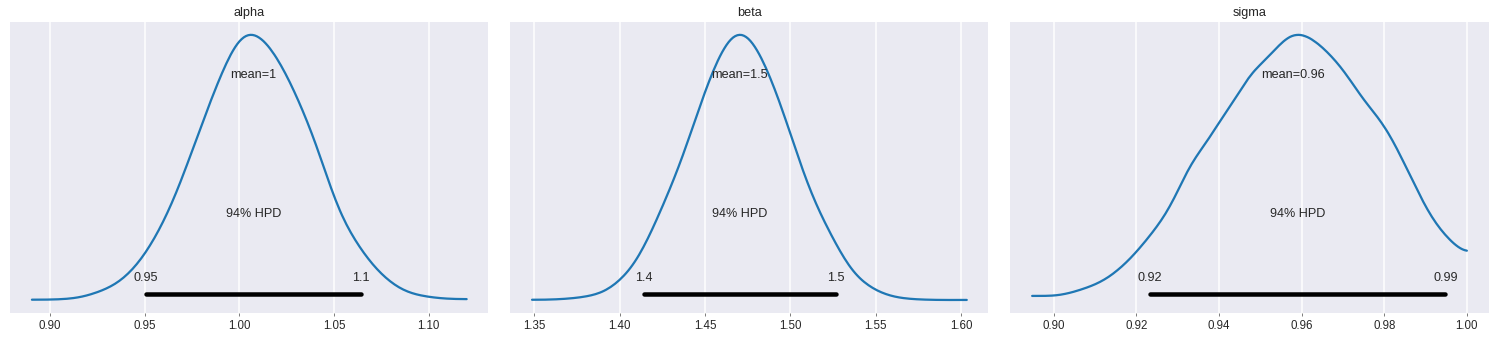

In [61]:
# Plotting Posteriors directly with PyMC3

pm.plot_posterior(trace);

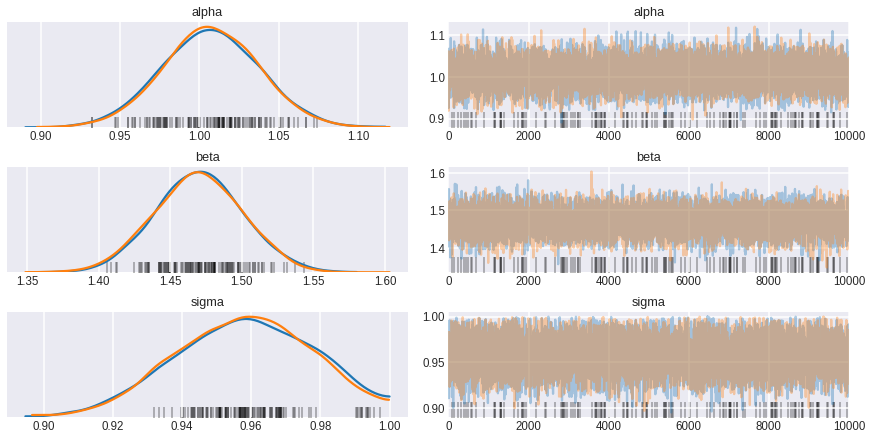

In [62]:
# Plotting full trace information

pm.plot_trace(trace);

**Note:** the more data available, the less priors define posteriors.

### TensorFlow Probability

In [0]:
# Model definition

def joint_log_prob(X_data_, Y_data_, alpha, beta, sigma):
    """
    Our posterior log probability, as a function of states
    
    Args:
      alpha_: scalar, taken from state of the HMC. y-intercept
      beta_: scalar, taken from state of the HMC. slope
      sigma_: scalar, the standard deviation of , taken from state of the HMC
    Returns: 
      Scalar sum of log probabilities
    Closure over: Y_data, X_data
    """
    
    # create random variables for priors for sigma, alpha, and beta
    rv_std = tfd.Uniform(name="std", low=0., high=1.)
    rv_beta = tfd.Normal(name="beta", loc=0., scale=10.)
    rv_alpha = tfd.Normal(name="alpha", loc=0., scale=10.)
    
    
    mean = alpha + beta * X_data_
    rv_observed = tfd.Normal(name="obs", loc=mean, scale=sigma)
    
    return (
        rv_alpha.log_prob(alpha) 
        + rv_beta.log_prob(beta) 
        + rv_std.log_prob(sigma)
        + tf.reduce_sum(rv_observed.log_prob(Y_data_))
    )

In [64]:
# Sampling from Hamiltonian Monte Carlo

number_of_steps = 4000
burnin = 800

# Set the chain's start state.
initial_chain_state = [
    tf.cast(x=1.,dtype=tf.float32) * tf.ones([], name='init_alpha', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_beta', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_sigma', dtype=tf.float32)
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(X, Y, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Initialize the step_size_adaptation_step_counter, else you get TF error messages
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size_adaptation_step_counter = tf.get_variable(
        name='step_size_adaptation_step_counter',
        initializer=tf.constant(0.0, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )    
    # Defining the HMC
    hmc=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn= tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin*0.9)),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    alpha, 
    beta, 
    sigma
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin, # HMC gets rid of our burnin iterations automatically
    current_state=initial_chain_state,
    kernel=hmc,
    name='HMC_sampling'
) 
    

# Initialize any created variables for preconditions
init_g = tf.global_variables_initializer()

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:494: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [70]:
# Evaluating the graph generated above

def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.contrib.framework.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)

#print(tf.executing_eagerly())

evaluate(init_g)

[
    alpha_,
    beta_,
    sigma_,
    kernel_results_
] = evaluate([
    alpha,
    beta,
    sigma,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

True
acceptance rate: 0.0
final step size: 0.00038688394124619663


In [78]:
kernel_results

TransformedTransitionKernelResults(transformed_state=[<tf.Tensor: id=27228014, shape=(4000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: id=27228015, shape=(4000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: id=27228016, shape=(4000,), dtype=float32, numpy=array([5., 5., 5., ..., 5., 5., 5.], dtype=float32)>], inner_results=MetropolisHastingsKernelResults(accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(log_acceptance_correction=<tf.Tensor: id=27228017, shape=(4000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, target_log_prob=<tf.Tensor: id=27228018, shape=(4000,), dtype=float32, numpy=array([-inf, -inf, -inf, ..., -inf, -inf, -inf], dtype=float32)>, grads_target_log_prob=[<tf.Tensor: id=27228019, shape=(4000,), dtype=float32, numpy=
array([-0.45581594, -0.45581594, -0.45581594, ..., -0.45581594,
       -0.45581594, -0.45581594], dtype=float32)>, <tf.Te

Text(0.5, 1.0, 'posterior alpha (α) samples')

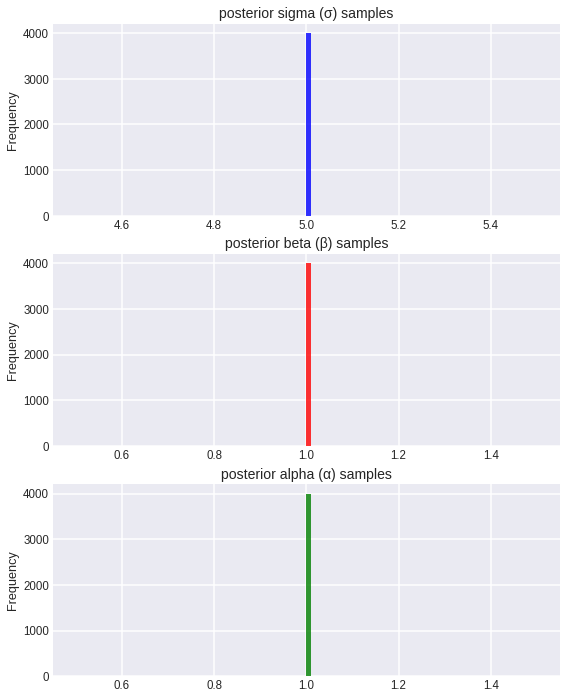

In [74]:
# Plotting the Posterior samples

# plotting the Posterior Samples

plt.figure(figsize=(20,12))
plt.subplot(3, 2, 1)
plt.hist(sigma_, 
         bins=100, color='B', alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior sigma (σ) samples', fontsize=14)


plt.subplot(3, 2, 3)
plt.hist(beta_, 
         bins=100, color='r', alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta (β) samples', fontsize=14)


plt.subplot(3, 2, 5)
plt.hist(alpha_, bins=100, 
         color='g', alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior alpha (α) samples', fontsize=14)